# Exploring the NWM Reanalysis dataset

## Download a timeseries of compressed netcdf files from gs (national-water-model-v2), then plot the streamflow at one ComID and export the time series as CSV file

In [1]:
from reanalysis import get_reanalysis_paths_gs, data_access_gs, plotReanalysis
import gcsfs
import json
import os
import urllib3
import xarray as xr
import pandas as pd
from glob import glob
from time import time
from IPython.display import IFrame
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
def new_plot(x_label='Time (hr)', y_label='Discharge (cfs)', figsize=(20,6), fontsize=18) -> plt.subplots:
    '''Return a created new plotframe.'''
    
    fig,  ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=2)
    return fig, ax

In [3]:
def get_NWM_rc(comid, rc_filepath=r"data/hydroprop-fulltable2D.nc") -> (interp1d, pd.DataFrame):
    """Opens the hydroprop-fulltable2D.nc file and retireves rating curves.
    This is available for download at: 
    https://web.corral.tacc.utexas.edu/nfiedata/hydraulic-property-table/.
    More information can be found at: https://web.corral.tacc.utexas.edu/nfiedata/.
    """
    ds = xr.open_dataset(rc_filepath)
    dis_ds = ds.Discharge.sel(CatchId=comid)
    dis_df = dis_ds.to_dataframe().reset_index().drop(columns=["CatchId"]).dropna()
    f = interp1d(dis_df.Discharge, dis_df.Stage, kind="cubic")
    return f, dis_df

In [4]:
def open_station_website(USGS_ID:str) -> IFrame:
    '''Open the selected USGS station website. Users can use this website to prepare the required parameters for retrieving the desired records.'''
    
    return IFrame(src="https://waterdata.usgs.gov/usa/nwis/uv?{}".format(USGS_ID), width='100%', height='500px')

In [5]:
def usgs_data(station_id:str, start_date:str, end_date:str, parameter:str) -> dict:
    '''Retrieve time series data for a USGS gauge.'''
        
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    http = urllib3.PoolManager()

    # Define URL parameters    
    data_format = "json"
    station_id = station_id
    start_date = start_date
    end_date = end_date
    parameter = parameter
    site_type = "ST"
    site_status = "all"
    
    # Build the URL to retrieve the data
    st_service_url = "https://nwis.waterservices.usgs.gov/nwis/iv/?format="+ data_format +\
    "&sites="+ station_id +"&startDT="+ start_date +"&endDT="+ end_date +"&parameterCd="+ parameter +\
    "&siteType="+ site_type +"&siteStatus="+ site_status
    url = http.request('GET', st_service_url).data
    response = json.loads(url)
    usgs_values = response['value']['timeSeries'][0]['values'][0]['value']
    
    # usgs_values = {'value': value in str, 'qualifiers': qualifiers in str, 'dateTime': dateTime in str}
    return usgs_values

In [6]:
start_date = '2016-10-05'
end_date = '2016-10-15'
freq = "1H"

In [7]:
fs = gcsfs.GCSFileSystem(project='national-water-model-v2')

In [8]:
subfolders=fs.ls('national-water-model-v2')

In [9]:
subfolders

['national-water-model-v2/full_physics/',
 'national-water-model-v2/long_range/']

In [10]:
records_wanted = list(pd.date_range(start_date, end_date, freq=freq).strftime('%Y%m%d%H%M'))

In [11]:
file_paths = []
for record in records_wanted:
    file_paths.append(subfolders[0] + record[:4] + "/" + record +'.CHRTOUT_DOMAIN1.comp')

In [12]:
file_paths[0]

'national-water-model-v2/full_physics/2016/201610050000.CHRTOUT_DOMAIN1.comp'

In [13]:
openfiles = [fs.open(f, "rb") for f in file_paths]

In [14]:
len(openfiles)

241

In [15]:
all_data = xr.open_mfdataset(openfiles)

## Begin exploration

In [16]:
start = time()
start

1574371430.553504

In [17]:
comid = 8785685
files = glob('data/*')

In [18]:
df = all_data.sel(feature_id=comid)['streamflow'].to_dataframe().drop(columns=['feature_id', 'latitude', 'longitude'])

In [19]:
df.head()

,streamflow
time,
2016-10-05 00:00:00,29.239999
2016-10-05 01:00:00,29.159999
2016-10-05 02:00:00,29.089999
2016-10-05 03:00:00,29.029999
2016-10-05 04:00:00,28.959999


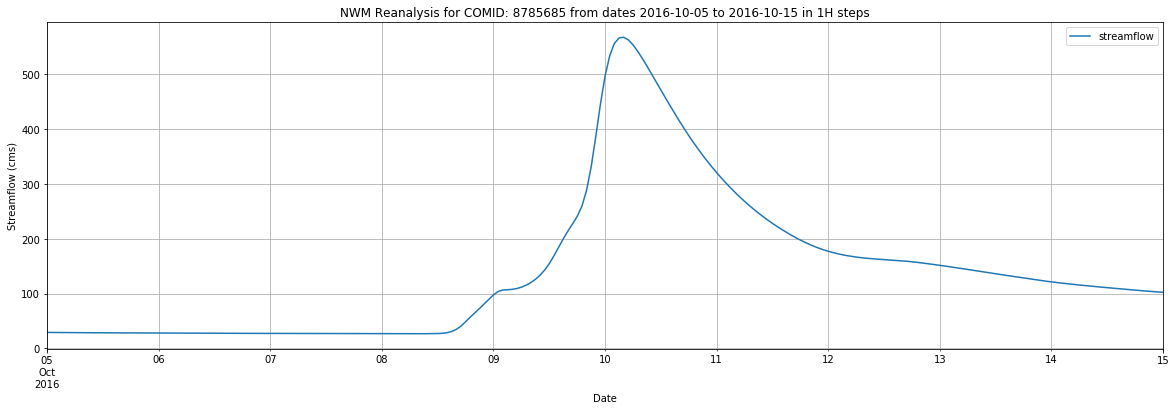

In [20]:
plotReanalysis(df, comid, freq)

In [21]:
print(round((time()-start), 2), 'seconds to access', sum([os.path.getsize(f) for f in files])/1e9, 'GB of data and produce a time series plot')

622.0 seconds to access 0.0 GB of data and produce a time series plot


In [22]:
nwm_rc_path = r"C:\Users\mmorsy\Documents\GitHub\fcast\notebooks\data\hydroprop-fulltable2D.nc"

ds = xr.open_dataset(nwm_rc_path)

In [23]:
f, nwm_rc = get_NWM_rc(comid, nwm_rc_path)

In [24]:
nwm_rc.head()

,Stage,Discharge
0,0.0000,0.000000
1,0.3048,0.293121
2,0.6096,0.987556
3,0.9144,2.014828
4,1.2192,3.333481


In [25]:
f(0.293121)

array(0.30479972)

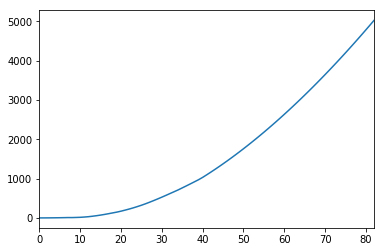

In [26]:
nwm_rc.Discharge.plot()

In [27]:
stage_df = df.apply(f).rename(columns={'streamflow': 'stage'})

In [28]:
stage_df.head()

,stage
time,
2016-10-05 00:00:00,3.633636
2016-10-05 01:00:00,3.632522
2016-10-05 02:00:00,3.631543
2016-10-05 03:00:00,3.630698
2016-10-05 04:00:00,3.629707


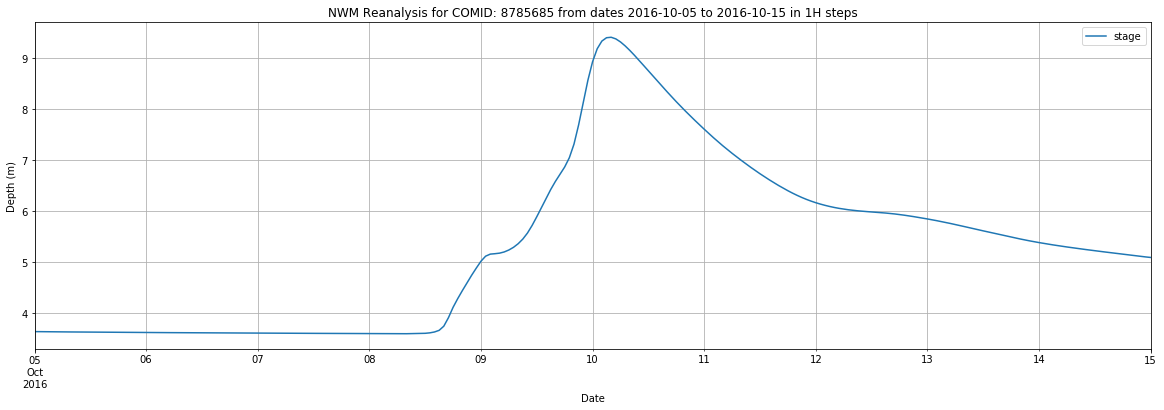

In [29]:
plotReanalysis(stage_df, comid, freq, flow=False)

In [62]:
USGS_ID = '02087570'
parameter = "00065"  # USGS discharge code

In [63]:
open_station_website(USGS_ID)

In [64]:
start_date_of_record = "2016-10-05"  # Start of record
end_date_of_record = "2016-10-15"    # End of record

In [65]:
usgs_values = usgs_data(USGS_ID, start_date_of_record, end_date_of_record, parameter)

In [66]:
usgs_df = pd.DataFrame.from_records(usgs_values)
usgs_df.head()

,dateTime,qualifiers,value
0,2016-10-05T00:00:00.000-04:00,[A],7.37
1,2016-10-05T00:15:00.000-04:00,[A],7.36
2,2016-10-05T00:30:00.000-04:00,[A],7.36
3,2016-10-05T00:45:00.000-04:00,[A],7.35
4,2016-10-05T01:00:00.000-04:00,[A],7.33


In [67]:
max(usgs_df.value)

'9.98'

In [61]:
usgs_df.head()

,dateTime,qualifiers,value
0,2016-10-05 00:00:00-04:00,[A],7.37
1,2016-10-05 00:15:00-04:00,[A],7.36
2,2016-10-05 00:30:00-04:00,[A],7.36
3,2016-10-05 00:45:00-04:00,[A],7.35
4,2016-10-05 01:00:00-04:00,[A],7.33


In [35]:
usgs_df = usgs_df[usgs_df.value != '-999999']
usgs_df['dateTime'] =  pd.to_datetime(usgs_df['dateTime'], utc=False)
usgs_df['value']= pd.to_numeric(usgs_df['value']) * 0.3048 #if stage, multiply by 0.3048 to change the units from feet to meter
usgs_df = usgs_df.assign(increment_hr = usgs_df.dateTime.diff())
usgs_df.head()

,dateTime,qualifiers,value,increment_hr
0,2016-10-05 00:00:00-04:00,[A],2.246376,NaT
1,2016-10-05 00:15:00-04:00,[A],2.243328,00:15:00
2,2016-10-05 00:30:00-04:00,[A],2.243328,00:15:00
3,2016-10-05 00:45:00-04:00,[A],2.240280,00:15:00
4,2016-10-05 01:00:00-04:00,[A],2.234184,00:15:00


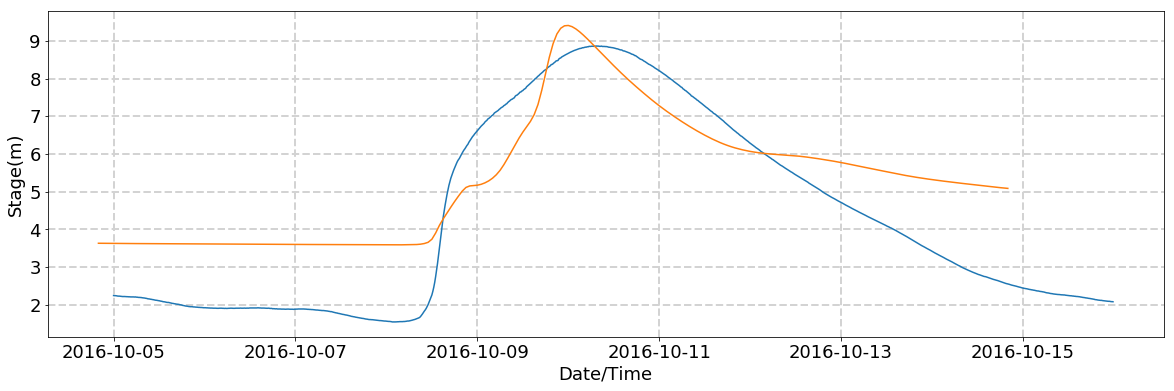

In [36]:
fig, ax = new_plot(x_label='Date/Time', y_label='Stage(m)')
ax.plot(usgs_df.dateTime, usgs_df.value)
ax.plot(stage_df)

# End